<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p>
  <img alt="Colaboratory logo" width="150" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/1-polito.png" style="float: left; margin-right: 20px; margin-bottom: 10px;">
</p>    
<h1>
<h2><strong> Homework 2 - Network Dynamics and Learning </strong></h2>
<h3>Corso di Laurea Magistrale in DATA SCIENCE AND ENGINEERING</h3>


|Student| Email|
|:--:|:--:|
|Alejandra Solarte Uscategui| s321944@studenti.polito.it|
|Alejandro Mesa Gomez | s306638@studenti.polito.it|
|Anderson Estiver Alvarez Giraldo|  s310468@studenti.polito.it|
|Juliana Cortes Mendivil| s314545@studenti.polito.it|
|Mateo Rivera Monsalve|s320923@studenti.polito.it|

## Individual contributions

|Exercise|Student |
|:--:|:--:|
|1 (e,g)| Alejandra Solarte|
|| Alejandro Mesa|
|1 (c,d,h)| Anderson Alvarez|
|1 (f)| Juliana Cortes|
|1 (a,b),2,3| Mateo Rivera|

# Problem 1
The first part of this assignment consists in studying a single particule performing a continuous-time random walk in the network described by the graph in Fig. 1 and with the following transition rate matrix:

$\Lambda =
\begin{pmatrix}
0 & \frac{2}{5} & \frac{1}{5} & 0 & 0 \\
0 & 0 & \frac{3}{4} & \frac{1}{4} & 0 \\
\frac{1}{2} & 0 & 0 & \frac{1}{3} & 0 \\
0 & 0 & \frac{1}{3} & 0 & \frac{2}{3} \\
0 & \frac{1}{2} & 0 & \frac{1}{3} & 0
\end{pmatrix}
$
<figure>
    <img width="412" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H2/sources/G.png"/>
    <figcaption>Figure 1: Closed network in which particles move according to the transition rate matrix (1)</figcaption>
</figure>
Your task is to simulate the particle moving around in the network in continuous time according to the transition rate matrix (1).

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from numpy.random import choice, rand
%matplotlib inline
options = {
    'node_size': 500,
    'width': 1, # width of the edges,
    'node_color': '#ffffff',
    'node_shape': 'o',
    'edge_color': 'black',
    'font_weight':'normal'
}
import progressbar
import time

### Definition of the graph

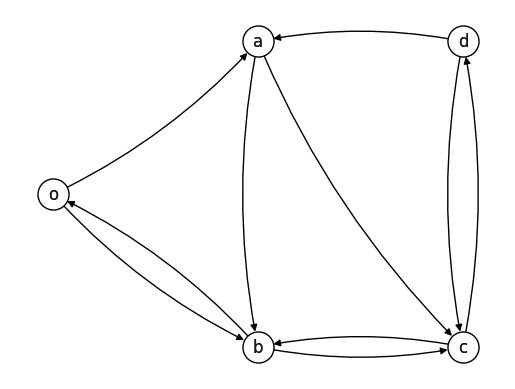

In [ ]:
#defining and printing the give graph
V = ['o', 'a', 'b', 'c', 'd']
E = [('o','a'), ('o','b'), ('a','b'), ('a','c'), ('b','c'), ('b','o'),
         ('c','b'), ('c','d'), ('d','a'), ('d','c')]

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)
pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'c':(80,5), 'd': (80, 35)}
node_list = list(G.nodes())


plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G, pos, with_labels=True, **options, connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

### Continuous Random-walk
We will use the first approach of the three ways we saw in class of modelling Continuous-Time Markov Chains which is described as follows

**1st approach**
1. you define a unique **global** Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when you are at node $i$ and **the global clock ticks**, either you jump to a neighbor $j$ with probability $\bar P_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or you stay in the same node (no transition) with probability $\bar P_{ii} = 1 - \sum_{i \neq j} \bar P_{ij}$.

In this approach, the continuous time is discretized using a global clock, while the matrix Q describes the jumps. For this reason the matrix $\bar P$ is called **jump chain** of the CTMC.

Notice that $\bar P_{ii}=0$ for the nodes $i$ maximizing $\omega$, and it is larger as $\omega_i/\omega$ is small.

**Function to simulate a Continuos random walk**

* `P_bar` = The $\bar{P}$ matrix of the graph
* `x_0`, `x_n` = Node to start and to end the walk
* `n_steps` = Number of jump to do considered only if `end_node` is `None` and `n_steps != -1` (If `x_n == None` and `n_steps <= 0` the random walk stops the first time it returns to the starting node `x_0`)

In [ ]:
def compute_P_bar(Lambda):
    # Defining w for the clock in continuos time
    w = np.sum(Lambda, axis=1)
    w_star = np.max(w)

    # Defining P_bar (we are in continuos time)
    P_bar = Lambda/w_star
    P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

    return P_bar, w_star

In [ ]:
# Simulates a random walk on the graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

def ContinuousTimeRandomWalk(Lambda, x_0, x_n = None, n_steps=-1):
    till_x_0_return = n_steps <= 0 and x_n is None

    P_bar, w_star = compute_P_bar(Lambda)
    n_states = len(P_bar)

    # walk stores the sequence of visited nodes
    walk = [x_0]

    # transition_times will store the time instants at which
    # jumps/transitions happen
    transition_times = [0]

    current_pos = 1

    # No upper bound on the number of steps
    while current_pos != n_steps + 1:
        # The random time to wait for the next transition
        # is drawn according to its distribution, as discussed in Remark 1
        # NOTE: in the formula for t_next we use w_star, the rate of the "global" Poisson clock
        t_next = np.random.exponential(1/w_star)

        # The next state to visit will be extracted according to the probabilities
        # stored in the row of P_bar corresponding to the current state.
        # We extract a value pos[i] in (0,...,num_states-1) according to the discrete distribution P_bar[pos[i-1],:]
        walk.append(np.random.choice(n_states, p=P_bar[walk[current_pos-1],:]))
        transition_times.append(transition_times[current_pos-1] + t_next)

        # Check if the walk has returned to the starting node
        # or the walk arrived to the end node
        # if so, end the walk
        if walk[current_pos] == x_0 and till_x_0_return or walk[current_pos] == x_n:
            return walk, transition_times

        current_pos += 1

    return walk, transition_times

In [ ]:
def SingleParticleSimulations(Lambda, start_node, n_simulations, end_node = None, n_steps = -1, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(ContinuousTimeRandomWalk(Lambda, start_node, end_node, n_steps))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

## Point a
What is, according to the simulations, the average time it takes a particle that starts in node $a$ to leave the node and then return to it?


In [ ]:
# Defining Lambda
Lambda = np.array([
     [0, 2/5, 1/5, 0, 0],
     [0, 0, 3/4, 1/4, 0],
     [1/2, 0, 0, 1/3, 0],
     [0, 0, 1/3, 0, 2/3],
     [0, 1/2, 0, 1/3, 0]
])

# Defining P_bar (we are in continuous time)
P_bar, _ = compute_P_bar(Lambda)

# Compute pi_bar the invariant probability vector by determining the leading eigenvector of the matrix P_bar′
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


Simulations

In [ ]:
start_node = V.index('a')

In [ ]:
results_simulation = SingleParticleSimulations(Lambda, start_node, 10000)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:09 Time:  0:00:09


In [ ]:
times = [simulation[1][-1] for simulation in results_simulation]
print("Empirical average time to return in a starting from a:", np.mean(times))

Empirical average time to return in a starting from a: 6.136947466791511


## Point b
How does the result in a) compare to the theoretical return-time $\mathbb{E}_{a}\left ( T^{+}_{a}  \right )$? (Include a description of how this is computed)

**Solution**
The theoretical return time $\mathbb{E}_{a}\left ( T^{+}_{a}  \right )$ is given by the formula: $$\mathbb{E}_{a}\left ( T^{+}_{a}  \right )=\frac{1}{\omega_{a}\bar{\pi}_{a}}$$ where $\omega_{a}$ and $\bar{\pi}_{a}$ are previously computed values.

The value of $\omega_{a}$ is given by:
$$w_{a}=\sum_{j}\Lambda_{aj}=3/4+1/4=1$$
The stationary probability $\bar{\pi}_{a}$ corresponds to the value associated with node $a$ in the stationary probability vector of $\bar{P}'$, where $\bar{P}'$ is defined as:

$\bar{P}_{ij}=\frac{\Lambda_{ij}}{w_{*}}$, for $i\neq j$

$\bar{P}_{ii}=1-\sum_{j\neq i}\bar{P}_{ij}$

The computed stationary probability vector $\bar{\pi}$ is:
$$\bar{\pi}=\begin{pmatrix}
0.23058252 & 0.16504854 & 0.27669903 & 0.18203883 & 0.14563107  \\
\end{pmatrix}'$$
Thus, the theoretical return time for node $a$ is:
$$\mathbb{E}_{a}\left ( T^{+}_{a}  \right )\approx\frac{1}{1\times0.16504854}\approx6.058823529411766$$

In [ ]:
1 / pi_bar[V.index('a')]

6.058823529411766

In [ ]:
def plot_empirical_against_theoretical(simulations, min_sim = 2, n_simulations = None,
    theoretical_label = r'Theoretical $\mathbb{E}_{a}\left[ T^{+}_{a}  \right]$',
    title='Convergence of Empirical Average Return Time to Theoretical Value'):

    # n_simulations to take into account for plotting, if None, we will consider the whole simulation
    if n_simulations is None:
        n_simulations = len(simulations)

    # The x-axis, min_sim is the minimum number of simulations to take into account
    # As this function was created to plot an average, we will consider min_sim=2 as default
    x = np.arange(min_sim, min_sim + n_simulations)
    simulations = simulations[min_sim-2:min_sim-2 + n_simulations]

    plt.plot(x, simulations, 'r', label='Empirical average')
    plt.plot(x, 1 / pi_bar[V.index('a')]*np.ones(len(simulations)), 'g', label=theoretical_label)
    plt.xlabel('Number of simulations')
    plt.ylabel('Average time')
    plt.ylim(min(simulations)-1/3 , max(simulations)+1/3 )
    plt.legend()
    plt.title(title)
    plt.show()

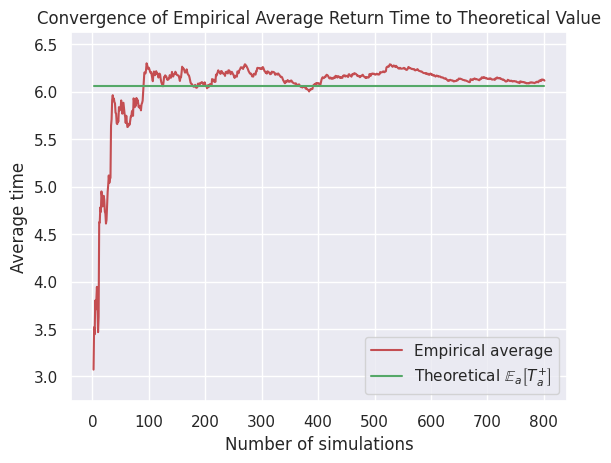

In [ ]:
average_simulations = np.cumsum(times)[1:]/np.arange(2,len(times)+1)
plot_empirical_against_theoretical(average_simulations, n_simulations=800)

## Point c
What is, according to the simulations, the average time it takes to move from node $o$ to node $d$?

In [ ]:
#change the start and end node
start_idx = V.index('o')
end_idx = V.index('d')

times_array = SingleParticleSimulations(P_bar,start_idx, 1000,end_idx)
avg_time = np.mean([matrix[1][-1] for matrix in times_array])
print("Empirical average time from o to d with 1000 simulations:",  avg_time)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


Empirical average time from o to d with 1000 simulations: 10.505633735439359


In [ ]:
#change the start and end node
start_idx = V.index('o')
end_idx = V.index('d')

times_array = SingleParticleSimulations(P_bar,start_idx, 10000,end_idx)
avg_time = np.mean([matrix[1][-1] for matrix in times_array])
print("Empirical average time from o to d with 10000 simulations",  avg_time)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:11 Time:  0:00:11


Empirical average time from o to d with 10000 simulations 10.847259616325587


In [ ]:
#change the start and end node
start_idx = V.index('o')
end_idx = V.index('d')

times_array = SingleParticleSimulations(P_bar,start_idx, 100000,end_idx)
avg_time = np.mean([matrix[1][-1] for matrix in times_array])
print("Empirical average time from o to d with 100000 simulations:",  avg_time)

100% (100000 of 100000) |################| Elapsed Time: 0:00:36 Time:  0:00:36


Empirical average time from o to d with 100000 simulations: 10.721976607330369


We simulated the chain from node $o$ and iterated until the chain reached node $d$. We repeated this process $N$ times and obtaining each time a measurement of the duration of said process equal to $T_{o-d}^{i}$. Later on, we obtained an empirical estimate of the average $o-d$ hitting time, $\mathbb{E}\left ( T_{d} \right )$.

In particular $\mathbb{E}\left ( T_{d} \right )=\frac{1}{N}\sum_{i=1}^{N}T_{o-d}^{i}\approx 10.755$

## Point d
How does the result in c) compare to the theoretical hitting-time $\mathbb{E}_{d}\left ( T_{d}  \right )$? (Describe also how this is computed.)

In [ ]:
w = Lambda @ np.ones(Lambda.shape[0])
# degree matrix
D = np.diag(w)
# jump probability matrix (row stochastic)
P = np.linalg.inv(D) @ Lambda
# P without node d
P_reduced = np.delete(np.delete(arr=P, obj=4, axis=0),obj=4, axis=1)
w_reduced = np.delete(arr=w, obj=4)

I = np.eye(len(w_reduced))  # identity matriz
A = I - P_reduced  # Matriz (I - P_reduced)
A, b = A, 1/w_reduced
hitting_time = np.linalg.solve(A, b)

In [ ]:
hitting_time[0]

10.766666666666666

<figure>
    <img width="700" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H2/sources/a2.1.d.png"/>
</figure>

## Point e

Interpret the matrix $ \Lambda $ as the weight matrix of a graph $ \mathcal{G}= (\mathcal{V},\mathcal{E}, \Lambda ) $ , and simulate the French-DeGroot dynamics on $ \mathcal{G} $ with an arbitrary initial condition $\mathcal{x}(0)$. Does the dynamics converge to a consensus state for every initial condition $\mathcal{x}(0)$? Motivate your answer

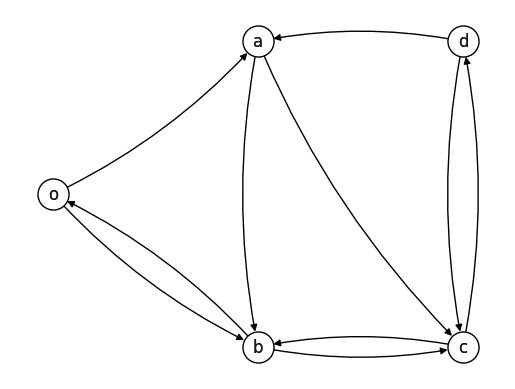

In [ ]:
#defining and printing the give graph
nodes = ['o', 'a', 'b', 'c', 'd']
edges = [('o','a'), ('o','b'), ('a','b'), ('a','c'), ('b','c'), ('b','o'),
         ('c','b'), ('c','d'), ('d','a'), ('d','c')]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'c':(80,5), 'd': (80, 35)}
node_list = list(G.nodes())


plt.subplot(111)

nx.draw(G, pos, with_labels=True, **options, connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos) #Draw node labels on the graph
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

From the graph, we can observe that it is strongly connected, as for all nodes 𝑖 and 𝑗, 𝑖 is reachable from 𝑗. Additionally, the graph is aperiodic because it is possible to return to a node in a varying number of steps, meaning it has a period of 1.

In [ ]:
#Already constructed P
#redraw for a moment the graph

#number of iterations to simulate
n_iter = 70

# matrix to store the opinions of the nodes at each time step
x = np.zeros((G.number_of_nodes(),n_iter))

#defining Lambda
Lambda = np.array([

    #o    a    b   c  d
     [0, 2/5, 1/5, 0, 0], #o
     [0, 0, 3/4, 1/4, 0], #a
     [1/2, 0, 0, 1/3, 0], #b
     [0, 0, 1/3, 0, 2/3], #c
     [0, 1/2, 0, 1/3, 0]  #d

])

#defining w for the clock in continuos time
w = np.sum(Lambda, axis=1)

#Compute matrices of graph G
P = np.linalg.inv(np.diag(w))@Lambda #P is the normlized weight matrix

# set an arbitrary initial condition (1,0,0,0,1) (There is consensus just if at the x(t) = x(0))
x[:,0] = np.random.rand(G.number_of_nodes())
print("The initial value is: ", x[:,0] )


# Calculate the vector of opinions at eah step
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]

x[:,n_iter-1]

The initial value is:  [0.9139062  0.46193987 0.75106684 0.66034211 0.92153542]


array([0.72596621, 0.72596621, 0.72596621, 0.72596621, 0.72596621])

After analyzing the evolution of the initial condition, we observe that all nodes eventually reach consensus. This indicates the existence of a single sink in the graph. Consequently $ \alpha = \pi'x(0) $  

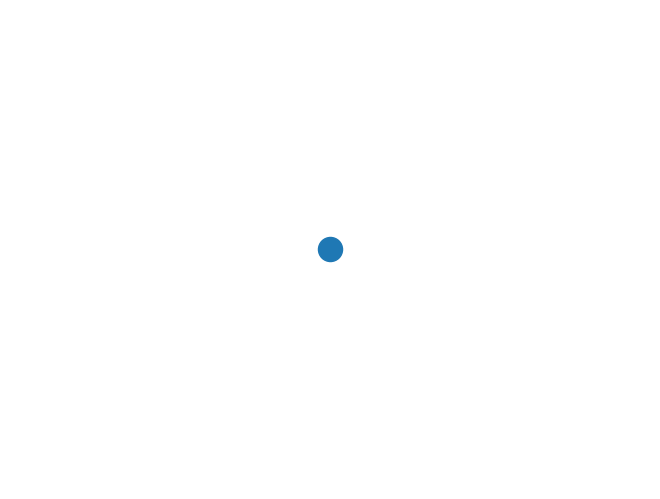

In [ ]:
CG = nx.algorithms.components.condensation(G)

nx.draw(CG)

When plotting the consensus graph, we observe the presence of a single sink, which ensures that the system reaches consensus. The consensus value $\alpha$ can be calculated using the weights provided by the (unique) invariant distribution. $\pi$.


In [ ]:
values,vectors = np.linalg.eig(P.T)

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(values[i],1)]:
    pi = vectors[:,index].real  # -> get the real part of the eigenvector
    pi = pi/np.sum(pi)
    print("pi", index, "=", pi)

#found pi, we have to multiply by the initial condition
x0 = x[:,0]


print("The consensus value is:", pi@x0)

pi 0 = [0.16521739 0.19710145 0.27536232 0.2173913  0.14492754]
The consensus value is: 0.7259662128133728


From the results, we observe that since all nodes belong to the sink, all values in the invariant distribution are non-zero, indicating that the evolution is influenced by all nodes. Recall that $\pi$ solving $\pi = P' \pi$ is also the invariant distribution centrality, thus the more a node is central the more its initial opinion affects the consensus value. Additionally, we can identify the most central node as $\mathcal{b}$ as it briefly has the greatest impact on the opinions of other nodes. It is followed in influence by nodes $\mathcal{c}$, $\mathcal{a}$, $\mathcal{o}$, and finally $\mathcal{d}$, in this order.

However, since the differences in influence are not significant, changing the opinion of node $\mathcal{b}$ would not drastically affect the consensus value.

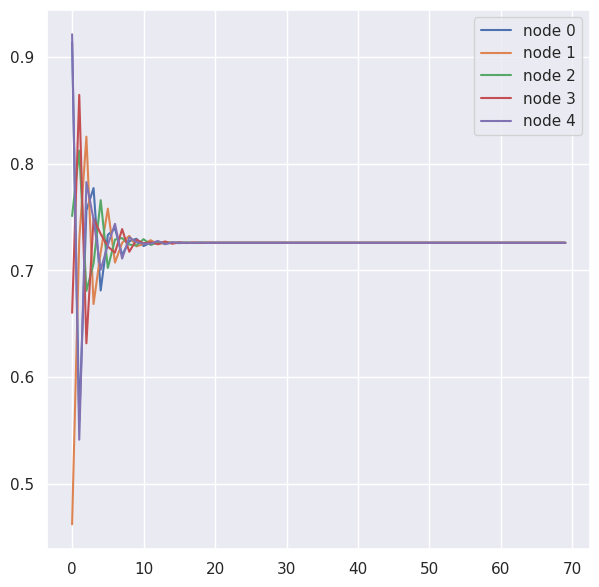

In [ ]:
#plot the record of the consensus vector to have a better look of the convergence
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))

ax.legend()

## Point f
Assume that the initial state of the dynamics for each node i $\epsilon$ $\mathcal{V}$ is given by xi(0) = $\xi_{i}$,
where $\xi_{i}$ i $\epsilon$ $\mathcal{V}$ are independent random variables with variance

$\sigma_a^2$ = $\sigma_b^2$ = $\sigma_c^2$ = 2 , $\sigma_o^2$ = $\sigma_d^2$ = 1

Compute the variance of the consensus value, and compare your results with the numerical simulations.

In [ ]:
#defining w for the clock in continuos time
w = np.sum(Lambda, axis=1)

#Compute matrices of graph G
P = np.linalg.inv(np.diag(w))@Lambda #normlized weight matrix

# Number of nodes in the graph
n_nodes = G.number_of_nodes()

In [ ]:
# Define node-specific variances
node_variances = {
    'o': 1,
    'a': 2,
    'b': 2,
    'c': 2,
    'd': 1
}

# Mapping nodes to their respective variances
variances = np.array([node_variances[node] for node in G.nodes()])

# Compute mean and theoretical variance
mu = 1/2
var = np.mean(variances)
# Given stationary distribution, from point a)
pi_bar = np.array([0.23058252, 0.16504854, 0.27669903, 0.18203883, 0.14563107])

# Theoretical variance
theoretical_variance = var * np.sum(pi_bar**2)

n_sim = 1000
quad_err = np.zeros(n_sim)

# Evolution of the dynamics
for sim in range(n_sim):
    # Sample initial state according to node-specific variances
    # The scale parameter specifies the standard deviation (sigma) of the normal distribution, but we are working with variances
    x0 = np.random.normal(loc=mu, scale=np.sqrt(variances))
    x = x0
    for n in range(15):  # n_iter from previous dynamics
        x = P @ x
    consensus_mean = np.mean(x)
    quad_err[sim] = (mu - consensus_mean) * (mu - consensus_mean)

# The variance sigma_alpha will be the mean of the quadratic error of each simulation
print("Expected value of the consensus value (alpha):", sum(pi_bar * mu))
print("Theoretical variance of the consensus value (alpha):", theoretical_variance)
print()
print("Variance of the starting state:", var)
print("Variance of the consensus value (alpha):", np.mean(quad_err))
print("The variance of the consensus value is always less than the variance of the initial state. It is a value close to the theoretical variance")

Expected value of the consensus value (alpha): 0.499999995
Theoretical variance of the consensus value (alpha): 0.3381091463451788

Variance of the starting state: 1.6
Variance of the consensus value (alpha): 0.38782781570211466
The variance of the consensus value is always less than the variance of the initial state. It is a value close to the theoretical variance


The simulation results closely match the theoretical variance, confirming the correctness of the consensus dynamics. As expected, the variance of the consensus value is lower than the variance of the initial states, due to the fact that consensus process averages out fluctuations, reducing variability.

## Point g
Remove the edges (d; a); (d; c); (a; c); (b; c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to an asymptotic state, how is such a state related to the initial condition x(0)?

In [ ]:
def removeEdge(edge, W, nodes):
    start = nodes.index(edge[0])
    end = nodes.index(edge[1])
    print(W[start,end],"->",0)
    W[start,end] = 0
    return W

In [ ]:
W1 = Lambda.copy()
#Removing (d,a)
W1 = removeEdge(('d','a'), W1, node_list)
#Removing (d,c)
W1 = removeEdge(('d','c'), W1, node_list)
#Removing (a,c)
W1 = removeEdge(('a','c'), W1, node_list)
#Removing (b,c)
W1 = removeEdge(('b','c'), W1, node_list)


0.5 -> 0
0.3333333333333333 -> 0
0.25 -> 0
0.3333333333333333 -> 0


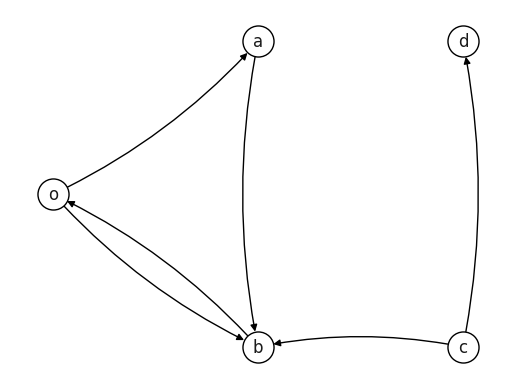

In [ ]:
#Updating the graph
G1 = nx.from_numpy_array(W1, parallel_edges=True, create_using=nx.DiGraph)
mapping = {
    0:'o',
    1:'a',
    2:'b',
    3:'c',
    4:'d'
}
G1 = nx.relabel_nodes(G1, mapping)
plt.subplot(111)
nx.draw(G1, pos,with_labels=True, **options, connectionstyle="arc3,rad=0.1")
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

As node $d$ has out-degree 0 it is necessary to add a self-loop and update $W1$

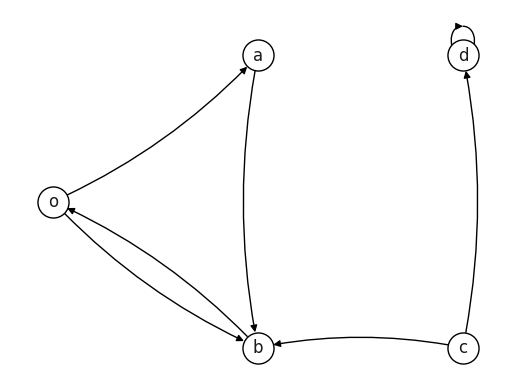

In [ ]:
G1.add_edge('d','d')
plt.subplot(111)
nx.draw(G1, pos,with_labels=True, **options, connectionstyle="arc3,rad=0.1")
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

Now d is an absorbent node because its only going out is itself

In [ ]:
W1 = nx.adjacency_matrix(G1).toarray()

In [ ]:
W1 #Now the las value on the diagonal is different from 0

array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
degs=np.sum(W1,axis=1)
D1 = np.diag(degs)
P1 = np.linalg.inv(D1) @ W1

In [ ]:
P1

array([[0.        , 0.66666667, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
#Compute consensus with the eigenvector method
def consensus(P,x0):
    values,vectors = np.linalg.eig(P.T)

    # selects the eigenvalue 1 and print the eigenvector
    for index in [i for i in range(P.shape[0]) if np.isclose(values[i],1)]:
        pi = vectors[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
        pi = pi/np.sum(pi)

    #found pi, we have to multiply by the initial condition
    return x0, pi@x0

Simulation of the dynamic evolution

In [ ]:
#Simulating the dynamic evolution
x0 = [20,0,0,0,1]
x=x0
n_iter = 100
for n in range(n_iter):
    #n_iter from previous dynamics
    x = P1 @ x
initial, value = consensus(P1, x0)
print("Consensus value:", value)
print("Initial state:", x0)
print("Empirical consensus value:", x.mean())
print()

Consensus value: 1.0
Initial state: [20, 0, 0, 0, 1]
Empirical consensus value: 5.333333334651733



In [ ]:
x0 = [50,2,32,1,0]
x=x0
n_iter = 100
for n in range(n_iter):
    #n_iter from previous dynamics
    x = P1 @ x
initial, value = consensus(P1, x0)
print("Consensus value:", value)
print("Initial state:", x0)
print("Empirical consensus value:", x.mean())
print()

Consensus value: 0.0
Initial state: [50, 2, 32, 1, 0]
Empirical consensus value: 20.833333339131975



In [ ]:
n_iter = 100
x0 = np.random.rand(G1.number_of_nodes())
x=x0
for n in range(n_iter): #n_iter from previous dynamics
    x = P1 @ x
initial, value = consensus(P1, x0)
print("Consensus value:", value)
print("Initial state:", x0)
print("Empirical consensus value:", x.mean())
print()

Consensus value: 0.1885813537932517
Initial state: [0.59201636 0.45242846 0.25366692 0.30837661 0.18858135]
Empirical consensus value: 0.3496860137643705



As d is an absorbent node at the end the real consensus value will be the value in that node (d) at the begining $x(0)$

## Point h

Consider the graph ($\mathcal{V}$, $\mathcal{E}$, $\Lambda$), and remove the edges (b; o) and (d; a). Analyse the French-DeGroot dynamics on the new graph. In particular, describe how the asymptotic behaviour of the dynamics varies in terms of the initial condition x(0), and motivate your answer.

In [ ]:
import copy
#Removing (d,a) and (d,c)
W2 = Lambda.copy()
W2 = removeEdge(('b','o'), W2, node_list)
W2 = removeEdge(('d','a'), W2, node_list)
W2

0.5 -> 0
0.5 -> 0


array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ]])

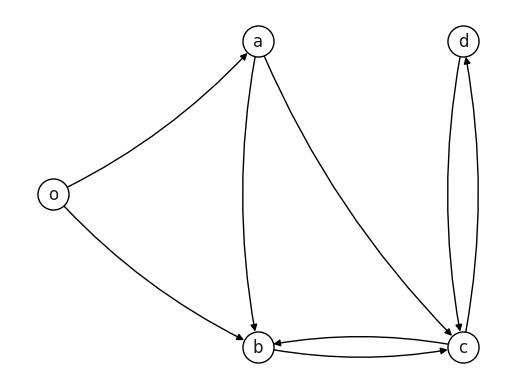

In [ ]:
G2 = nx.convert_matrix.from_numpy_array(W2, parallel_edges=True,create_using = nx.DiGraph)
mapping = {
    0:'o',
    1:'a',
    2:'b',
    3:'c',
    4:'d'
}
G2 = nx.relabel_nodes(G2, mapping)
plt.subplot(111)
nx.draw(G2, pos,with_labels=True, **options, connectionstyle="arc3,rad=0.1")
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

In [ ]:
print('strongly connected components:')

for s in nx.strongly_connected_components(G2):
    print(s)

bool_var = nx.is_aperiodic(G2.subgraph(nodes= ['b','c','d']))
print(f'is subgraph bcd aperiodic?: {bool_var}')

strongly connected components:
{'d', 'b', 'c'}
{'a'}
{'o'}
is subgraph bcd aperiodic?: False


Initial state: [ 1.53028098 -1.08636632  2.63271683  0.77762073  0.45483467] 

Final state: [0.97920806 1.08000173 0.77762073 1.18079539 0.77762073] 



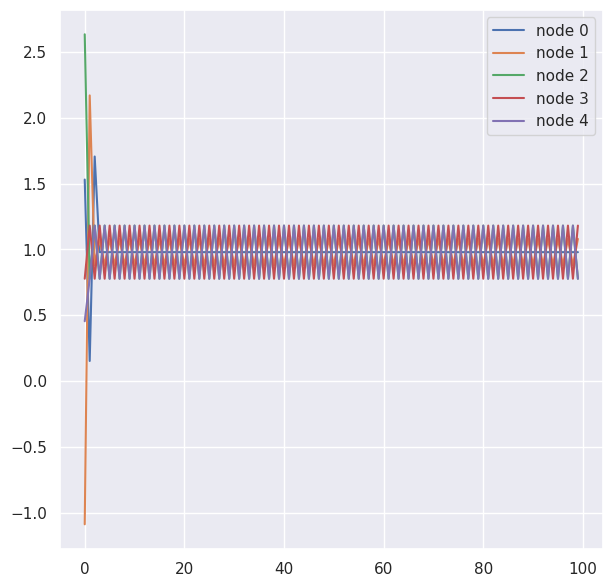

In [ ]:
D_h = np.diag(W2.sum(axis=1))
P_h = np.linalg.inv(D_h) @ W2

x = np.zeros((5,100))

x0 = np.random.normal(0, [np.sqrt(2), 1, 1, 1, np.sqrt(2)])

x[:,0] = x0

print("Initial state:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[:, t] = P_h @ x[:, t-1]

print("Final state:", x[:,n_iter-1], "\n")


fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(5):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))

ax.legend()

Removing the edges (b,o) and (d,a) from the lambda matrix into a not fully connected version, namely the vertex set S={b,c,d} becomes an absorbing subgraph. The condesation graph of this new modified graph has the properties of being a strongly connected subgraph and periodic, for this reason convergence to the consesus state is not guaranteed.

On the other hand, the condensed subgraph composed of edges b, c, and d acts as an absorbing component. As a result, interactions are primarily concentrated in this region. This behavior is evident in the graph, which shows that while there is no global consensus, oscillatory interactions(non aperiodiciti) occur within this condensed subgraph.

The dynamics of the network's opinion evolution are heavily influenced by the initial conditions due to the graph's structural properties.Nodes that are disconnected or weakly connected retain influence predominantly from their own initial states rather than being swayed by the global network. This suggests that fragmented graph structures lead to partial agreement within clusters, preventing a global consensus. The behavior of such systems, as seen in the French-DeGroot model, highlights the sensitivity of the asymptotic state to the initial conditions and the structure of the network

# Problem 2
In this part we will again consider the network of Fig. 1, with weights (1). However, now we will simulate many particles moving around in the network in continuous time. Each of the particles in the network will move around just as the single particle moved around in Problem 1: the time it will stay in a node is exponentially distributed, and on average it will stay $\frac{1}{\omega_{i}}$ time-units in a node $i$ before moving to one of its outneighbors. The next node it will visit is based on the probability matrix $P=diag\left(\omega\right)^{-1}\Lambda$, where $\omega=\Lambda\mathbb{1}$.

Your task is to simulate this system from two different perspectives: the *particle perspective*, i.e. "follow the particle", and the *node perspective*, i.e. "observe from the node".

Simulating the system from a particle perspective is exactly as in Problem 1, but here you have to follow many particles instead. To simulate the system from the node perspective you instead have to observe the particles from the node. When doing this you do not have to care about each single particle, but only about the number of particles in the node. Note that at node $i$, each particle in that node will stay there on average $\frac{1}{\omega_{i}}$ time units. Therefore, the node will pass along particles at a rate proportional to the number of particles in the node. In fact, if at time $t$ the number of particles in node $i$ is $n_{i}\left(t\right)$, it will pass along particles at a rate of $n_{i}\left(t\right)\omega_{i}$. The departure times of the node can thus be seen as a Poisson process with rate $n_{i}\left(t\right)\omega_{i}$. At each tick of the Poisson clock of the node, it will move a particle to a neighboring node. The node to which the particle will move is again based on the normalized transition rate matrix $P$.

Simulate the system from the two perspectives, and then answer the following questions (we have again provided a hint below):

## Point a - Particle perspective
* If $N=100$ particles all start in node $a$, what is the average time for a particle to return to node $a$?

This is equivalent to running the function `SingleParticleSimulations` $100$ times

In [ ]:
print("Start node:", V[start_node])

Start node: a


In [ ]:
# N = Number of particles to simulate
N = 100
n_simulations = 10000
return_times_particle_perspective = np.zeros((N, n_simulations))

bar = progressbar.ProgressBar(max_value=N)
for i in range(N):
    simulation_particle = SingleParticleSimulations(Lambda, start_node, n_simulations, use_progressbar=False)
    return_times_particle_perspective[i, :] = [simulation[1][-1] for simulation in simulation_particle]
    bar.update(i+1)
bar.finish()

100% (100 of 100) |######################| Elapsed Time: 0:04:03 Time:  0:04:03


In [ ]:
print("Empirical average time to return in a starting from a:", np.mean(return_times_particle_perspective.mean(axis=1)))

Empirical average time to return in a starting from a: 6.069086482524726


* How does this compare to the answer in Problem 1, why?

**Simulation Results**

* Problem 2 (Particle Perspective with $N\times n\_simulations = 100 \times 10000$): The results were more accurate and closer to the theoretical expectations.

* Problem 1 (Single Particle, `n_simulations = 10000`): There was significant variance in the outcomes.
Comparison:

In Problem 2, the increased sample size inherently reduces the variance in the estimations. By following many particles over numerous simulations, the law of large numbers ensures convergence towards the theoretical values.

Conversely, in Problem 1, the analysis is based on a single particle over
`n_simulations = 10000`. This setup lacks the added accuracy provided by aggregating across multiple particles, resulting in higher variability.

From the particle perspective in Problem 2, simulating $N$ particles for `n_simulations` iterations can be viewed as equivalent to simulating a single particle for $n\times$ `n_simulations` iterations in Problem 1. This is because the behavior of $N$ particles over time effectively samples the system $N$ times more frequently, given the independence of particle movements.
This equivalence explains why the results in Problem 2, with $N\times n\_simulations$ simulations, are closer to the theoretical expectations: the increased sample size reduces statistical variance and improves the accuracy of the estimates.

## Point b - Node perspective
* If $N=100$ particles start in node $a$, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?
* Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time

In [ ]:
# Node perspective using a single, system-wide Poisson clock with rate Nw*
def NodeSimulationSSWPClock(Lambda, x_0, n_particles, time_limit):
    # Compute P_bar from Lambda
    P_bar, w_star = compute_P_bar(Lambda)
    n_states = len(P_bar)

    # transition_times will store the time instants at which
    # jumps/transitions happen
    transition_times = [0]
    current_time = 0

    # particles_in nodes[:, t] stores the number of particles in each node
    # at time current_time
    particles_in_nodes = np.zeros((n_states, 1))
    particles_in_nodes[x_0][0] = n_particles

    # No upper bound on the number of steps
    while current_time < time_limit:
        # The random time to wait for the next transition
        # is drawn according to its distribution, as discussed in Remark 1
        # NOTE: in the formula for t_next we use n_particles * w_star, the rate of the "global" Poisson clock
        t_next = np.random.exponential(1/(n_particles * w_star))

        # We need to select which particle to move
        current_n_particles_in_nodes = np.copy(particles_in_nodes[:, -1])
        origin_node = np.random.choice(n_states, p=current_n_particles_in_nodes/np.sum(current_n_particles_in_nodes))
        destination_node = np.random.choice(n_states, p=P_bar[origin_node,:])

        # Update the time because the clock ticked
        current_time += t_next
        transition_times.append(current_time)

        # Move the particle
        current_n_particles_in_nodes[origin_node] -= 1
        current_n_particles_in_nodes[destination_node] += 1
        particles_in_nodes = np.append(particles_in_nodes, current_n_particles_in_nodes.reshape(-1, 1), axis=1)

    return particles_in_nodes, transition_times

In [ ]:
def NodePerspectiveSimulations(Lambda, start_node, n_particles, time_limit, n_simulations, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(NodeSimulationSSWPClock(Lambda, start_node, n_particles, time_limit))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

In [ ]:
def plot_particles_per_node(V, transition_times, particles_in_nodes_history, width=12):
    plt.figure(figsize=(width, 6))
    for i in range(len(V)):
        plt.plot(transition_times, particles_in_nodes_history[i, :], label=f'Node ${V[i]}$')

    plt.xlabel('Time $t$')
    plt.ylabel('Number of particles')
    plt.legend()
    plt.title("Number of particles in each node during the simulation time")
    plt.show()

In [ ]:
simulation_node = NodePerspectiveSimulations(Lambda, start_node, 100, 60, 10000)

  2% (233 of 10000) |                    | Elapsed Time: 0:01:49 ETA:   1:16:13

In [ ]:
particles_in_nodes_last_iteration = simulation_node[0][0][:, -1].reshape(-1,1)
for i in range(len(simulation_node)):
    particles_in_nodes_last_iteration = np.append(particles_in_nodes_last_iteration, simulation_node[i][0][:, -1].reshape(-1,1), axis=1)

print("Average number of particles in the different nodes at the end of the simulation:", particles_in_nodes_last_iteration.mean(axis=1))

In [ ]:
particles_in_nodes, transition_times = simulation_node[-1]

In [ ]:
plot_particles_per_node(V, transition_times, particles_in_nodes)

* Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles

The stationary distribution $\bar{\pi}$ obtained from Problem 1 represents the long-term proportion of time a single particle spends in each node. It is given by:
$$\bar{\pi}=\begin{pmatrix}
0.23058252 & 0.16504854 & 0.27669903 & 0.18203883 & 0.14563107  \\
\end{pmatrix}'$$
In problem 2, we simulated 100 particles moving in the network and measured the average number of particles in each node at the end of the simulation. The observed particle distribution was: $$\widehat{\pi}=\frac{1}{100}\begin{pmatrix}
23.11908809 & 16.46455354 & 27.64653535 & 18.23307669 & 14.53674633  \\
\end{pmatrix}'$$
Comparing $\bar{\pi}$ and $\widehat{\pi}$, we observe that the values are nearly identical, with differences on the order of $10^{-4}$. This confirms that the simulated multi-particle system follows the same stationary distribution as a single particle in continuous-time random walk theory. The small discrepancies arise due to finite sampling effects, and they would diminish further with a larger number of particles or a longer simulation time.

# Problem 3
In this part we consider the open network of Figure 2, with transition rate matrix $\Lambda_{open}$ according to $(2)$.

$\Lambda_{open} =
\begin{pmatrix}
0 & \frac{3}{4} & \frac{3}{4} & 0 & 0 \\
0 & 0 & \frac{1}{4} & \frac{1}{4} & \frac{2}{4} \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$ $(2)$

<figure>
    <img width="412" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H2/sources/G2.png"/>
    <figcaption>Figure 2: Open network</figcaption>
</figure>
For this system, particles will enter the system at node $o$ according to a Poisson process with input rate $\lambda$. Each node will then pass along a particle according to a given rate, similar to what you did in Problem 2 with the "node perspective". Let $\omega=\Lambda\mathbb{1}$ and let $N\left(t\right)$ denote the vector of number of particles in each node at time $t$.

You will simulate two different scenarios that differ by what rate the nodes will pass along particles:

1. Proportional rate: Each node $i$ will pass along particles according to a Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node $i$, i.e., the node $i$ will pass along particles rate with rate $\omega_{i}N_{i}\left(t\right)$
2. Fixed rate: Each node $i$ will instead pass along particles with a fixed rate $\omega_{i}$.

Since node $d$ does not have a node to send its particles to, we assume that $\omega_{d}=2$. When the Poisson clock of node $d$ ticks, you could simply decrease the number of particles in the node by one (If there are any particles in the node). Equivalently think of another node $d'$ connected to node $d$, such that at every tick of the Poisson clock of $d$, it sends a particle to node $d'$.

In [ ]:
#defining and printing the given graph
V = ['o', 'a', 'b', 'c', 'd']
E = [('o','a'), ('o','b'), ('a','b'), ('a','c'), ('a', 'd'), ('b','c'),
     ('c','d')]

G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(E)
pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'c':(80,5), 'd': (80, 35)}
node_list = list(G.nodes())


plt.subplot(111)
nx.draw(G, pos, with_labels=True, **options, connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

In [ ]:
# Defining Lambda
Lambda = np.array([
     [0, 3/4, 3/4, 0, 0],
     [0, 0, 1/4, 1/4, 2/4],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0]
])

The goal is to simulate the two systems and answer the following questions:

## Point a - Proportional rate
* Simulate the system for $60$ time units and plot the evolution of the number of particles in each node over time with input rate $\lambda=100$.

In [ ]:
def PoissonProcessRate(w_i, N_i, fixed_rate):
    return w_i if fixed_rate else w_i * N_i

def ProportionalRateNodePerspective(Lambda, x_0, x_n, input_rate, time_limit, fixed_rate = False):
    # Compute P_bar from Lambda
    P_bar, _ = compute_P_bar(Lambda)
    n_states = len(P_bar)
    w = Lambda.dot(np.ones((n_states, 1))).reshape(-1)
    w[x_n] = 2

    # transition_times will store the time instants at which
    # jumps/transitions happen
    transition_times = [0]
    current_time = 0

    # clocks of each node
    clocks = np.zeros(n_states)

    # particles_in nodes[:, t] stores the number of particles in each node
    # at time current_time
    particles_in_nodes = np.zeros((n_states, 1))

    bar = progressbar.ProgressBar(max_value=time_limit)
    i = 0
    # No upper bound on the number of steps
    while current_time < time_limit:
        current_n_particles_in_nodes = np.copy(particles_in_nodes[:, -1])

        # The random time to wait the first input time
        t_input = np.random.exponential(1/input_rate)

        # Are there particles in the graph? Because we cannot
        # make transitions if there are not particles
        clocks[:] = [np.random.exponential(1/PoissonProcessRate(w[i], particles_in_nodes[i, -1], fixed_rate)) if particles_in_nodes[i, -1] != 0 else t_input + 1 for i in range(n_states)]

        # First clock in doing tick
        first_clock_tick = clocks.argmin()
        t_transition = clocks[first_clock_tick]

        #if t_input>t_transition:
        #   print(i, "t_input:", t_input, "with rate parameter", input_rate)
        #   print("First clock doing tick:", first_clock_tick, "with t_transition:", t_transition,"and rate parameter", w[first_clock_tick] * particles_in_nodes[first_clock_tick, -1], "\n"*2)


        # Input clock ticks first
        if t_input < t_transition:
            t_next = t_input
            # Add a new particle in x_0
            current_n_particles_in_nodes[x_0] += 1

        # Transition clock ticks first
        elif first_clock_tick == x_n:
            t_next = clocks[x_n]
            # Node x_n is a sink, remove the particle
            current_n_particles_in_nodes[first_clock_tick] -= 1

        else:
            t_next = clocks[first_clock_tick]
            destination_node = np.random.choice(n_states, p=P_bar[first_clock_tick,:])

            # Move the particle
            current_n_particles_in_nodes[first_clock_tick] -= 1
            current_n_particles_in_nodes[destination_node] += 1

        # Update the time because the clock ticked
        current_time += t_next
        transition_times.append(current_time)
        particles_in_nodes = np.append(particles_in_nodes, current_n_particles_in_nodes.reshape(-1, 1), axis=1)

        if current_time <= time_limit:
            bar.update(current_time)

    bar.finish()

    return particles_in_nodes, transition_times

In [ ]:
start_node = V.index('o')
end_node = V.index('d')

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 100, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

* What is the largest input rate that the system can handle without blowing up?

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 10, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 200, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 600, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 2000, 60)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

In this point, the system will  adjust itself to meet all the demand; each node will operate within the time depending of the number of particles accumulated in it.

## Point b - Fixed rate
* Simulate the system for $60$ time units and plot the evolution of the number of particles in each node over time with input rate $\lambda=1$.

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 1, 60, fixed_rate=True)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

* What is the largest input rate that the system can handle without blowing up? Motivate your answer

In [ ]:
particles_in_nodes, transition_times = ProportionalRateNodePerspective(Lambda, start_node, end_node, 1.865, 60, fixed_rate=True)
plot_particles_per_node(V, transition_times, particles_in_nodes, 16)

In this point, the system will no longer adjust itself to meet all the demand; instead, each node will operate within the agreed time, regardless of the number of particles accumulated in it. This explains why, at node 0, the accumulation of particles continuously increases—the more particles enter the system, the more congestion occurs. Consequently, node 0 becomes a bottleneck in the system, representing the new capacity constraint.